## Business Problem

Customer churn occurs when customers cease doing business with a firm. Retaining existing customers is more cost efficient than trying to attract new customers. With intense competition in the telecommunications industry, it would thus be advantageous for a firm to be able to predict if certain customers are likely to cease their service since the firm may attempt to persuade them to stay through various means such as attractive discounts or packages.

#### **Columns are masked in the data set** 

### Task and Approach:

* The goal is to predict target (Customer will churn or not ) by Using different machine learning algorithms 
  Here we are going to use Ridge regression(L2)

* The “Churn” column is our target.why a customer is leaving company products and what are factors leading customers to churn

In [1]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load
import matplotlib.pyplot as plt # Visuvalization & plotting
import seaborn as sns
import datetime  
from sklearn.linear_model import LogisticRegression #  Logistic Regression (aka logit) classifier in linear model
import joblib  #Joblib is a set of tools to provide lightweight pipelining in Python (Avoid computing twice the same thing)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
                                    # GridSearchCV - Implements a “fit” and a “score” method
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, make_scorer, accuracy_score, roc_curve, confusion_matrix, classification_report
                                    # Differnt metrics to evaluate the model 
import pandas_profiling as pp   # simple and fast exploratory data analysis of a Pandas Datafram

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder # Labeling the columns with 0 & 1

* Load data into the kernal
* Tdata = Telecom data

In [2]:
Tdata = pd.read_csv("../input/TelcoCustomerChurn.csv")

###  Data Quality and Missing value check

* Lets write one function to find out missing values ,unique values ,data types  

In [3]:
print ("Rows     : " ,Tdata.shape[0])
print ("Columns  : " ,Tdata.shape[1])
#print ("\nMissing values :  ", Tdata.isnull().sum())
#print ("\nUnique values :  \n",'Tdata.nunique()' + 'Tdata.info()')
#Tdata.info()

#def df_summary(df):
#df_U = Tdata.nunique()
#df_M = Tdata.isnull().sum()
#df_I = Tdata.dtypes
#df_U = df_U.to_frame().reset_index()
#df_M = df_M.to_frame().reset_index()
#df_I = df_I.to_frame().reset_index()
#df_U = df_U.rename(columns= {0: 'Unique Data'})
#df_M = df_M.rename(columns= {0: 'Missing Data'})
#df = pd.merge(df_U,df_M,on = 'index')

## Using all the above steps lets create function for summary for any given dataset  

def df_summary(df):
  df_U = df.nunique()
  df_M = df.isnull().sum()
  df_I = df.dtypes
  df_U = df_U.to_frame().reset_index()
  df_M = df_M.to_frame().reset_index()
  df_I = df_I.to_frame().reset_index()
  df_U = df_U.rename(columns= {0: 'Unique Data'})
  df_M = df_M.rename(columns= {0: 'Missing Data'})
  df_I = df_I.rename(columns= {0: 'Data Types'})
  output = pd.merge(pd.merge(df_M,df_U,on='index'),df_I,on='index')
  return output;


Rows     :  7043
Columns  :  21


In [4]:
df_summary(Tdata)

,index,Missing Data,Unique Data,Data Types
0,customerID,0,7043,object
1,gender,0,2,object
2,V1,0,2,int64
3,V2,0,2,object
4,V3,0,2,object
5,V4,0,73,int64
6,V5,0,2,object
7,V6,0,3,object
8,V7,0,3,object
9,V8,0,3,object


#### important points to note from above dataframe 

* From Data types  we can identify one 2 integer ,1 float ,18 string variables are there in our data         
* From Unique values                                     
   1.  13 variables having binary  & multi  class
   2.  We know that Customer ID has unique ness in the data
   3.  All variables are looking good but Surprislingly amoung all the variables  **V18** having many classes 

* We will look into the variables more closely 
  

In [5]:
Tdata.V18.head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: V18, dtype: object

* Seems the variables is wrongly classified as object data type .    
* We will convert into Numerical 

In [6]:
Tdata.V18= pd.to_numeric(Tdata.V18, errors='coerce')
Tdata.V18.describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: V18, dtype: float64

* Lets call summary function again to cross check the adjusments 

In [7]:
df_summary(Tdata)

,index,Missing Data,Unique Data,Data Types
0,customerID,0,7043,object
1,gender,0,2,object
2,V1,0,2,int64
3,V2,0,2,object
4,V3,0,2,object
5,V4,0,73,int64
6,V5,0,2,object
7,V6,0,3,object
8,V7,0,3,object
9,V8,0,3,object


* After coverting to numerical we have identified that there are **11 missig oberverations** are there for V18 Variable.

* Lets Impute the missing values with the **mean** of the variables since it has only 11

In [8]:
Tdata['V18'].fillna((Tdata['V18'].mean()), inplace=True)
Tdata['V18'].isnull().sum()
#df_summary(Tdata)

0

* As we dicussed above we will drop the customer id column since it will not give much infofor prediciton 

In [9]:
Tdata.drop('customerID',axis=1, inplace=True)
Tdata.columns

Index(['gender', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'Churn'],
      dtype='object')

* Lets seprate **Numerical columns**  and **object columns** seperatly 

In [10]:
Num_cols = Tdata.select_dtypes(include=['float64','int64']).columns.tolist()
Cat_cols = Tdata.select_dtypes(include=['object']).columns.tolist()
print("Number columns : ",Num_cols , "Catogarical columns :" ,Cat_cols,sep="\n")

Number columns : 
['V1', 'V4', 'V17', 'V18']
Catogarical columns :
['gender', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'Churn']


* Lets see all the categorical & Numerical  information one by one 
* Numerical variables we can use **describe function** directly 

In [11]:
Tdata[Num_cols].describe()

,V1,V4,V17,V18
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


* We can see those values w.r.to Target data 
* Lets plot these variables with target 

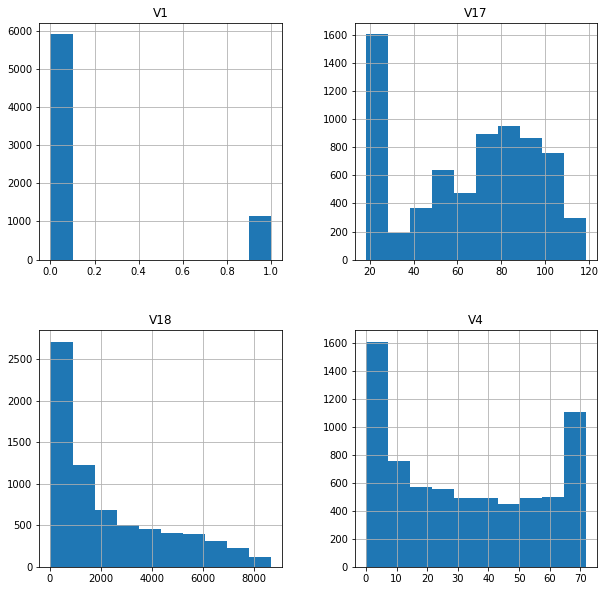

In [12]:
Tdata[Num_cols].hist(figsize = (10,10));

 * Data is skewed in V17 & V18 variables 

#### Lets see the binaary and multiclass variables 

* Creating function to see all the object data type variables using single function

In [13]:
def cat_col_desc(data):
    col_list = data.select_dtypes(include=['object']).columns.tolist()
    for i in col_list: 
        print("Variable :", i)
        print("Count of unique values :", len(set( data[i])))
        print("Unique values : " ,set( data[i]))
        print("================================")

In [14]:
cat_col_desc(Tdata)
#cat_col_desc(Tdata.loc[:, Tdata.columns != 'customerID']) # Since we have already dropped ID column no need

Variable : gender
Count of unique values : 2
Unique values :  {'Female', 'Male'}
Variable : V2
Count of unique values : 2
Unique values :  {'No', 'Yes'}
Variable : V3
Count of unique values : 2
Unique values :  {'No', 'Yes'}
Variable : V5
Count of unique values : 2
Unique values :  {'No', 'Yes'}
Variable : V6
Count of unique values : 3
Unique values :  {'No phone service', 'No', 'Yes'}
Variable : V7
Count of unique values : 3
Unique values :  {'DSL', 'No', 'Fiber optic'}
Variable : V8
Count of unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : V9
Count of unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : V10
Count of unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : V11
Count of unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : V12
Count of unique values : 3
Unique values :  {'No internet service', 'No', 'Yes'}
Variable : V13
Count of unique values : 3
Uniq

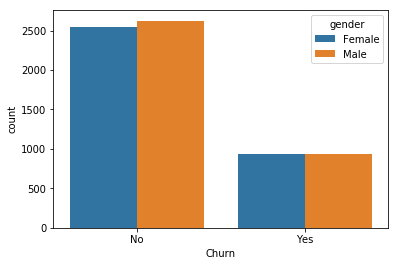

In [15]:
sns.countplot(x="Churn", hue="gender", data=Tdata)

In [16]:
Binary_class = Tdata[Cat_cols].nunique()[Tdata[Cat_cols].nunique() == 2].keys().tolist()
Multi_class =  Tdata[Cat_cols].nunique()[Tdata[Cat_cols].nunique() > 2].keys().tolist()
print(Binary_class)
print(Multi_class)

['gender', 'V2', 'V3', 'V5', 'V15', 'Churn']
['V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16']


* Look at Multi class variables distribution 

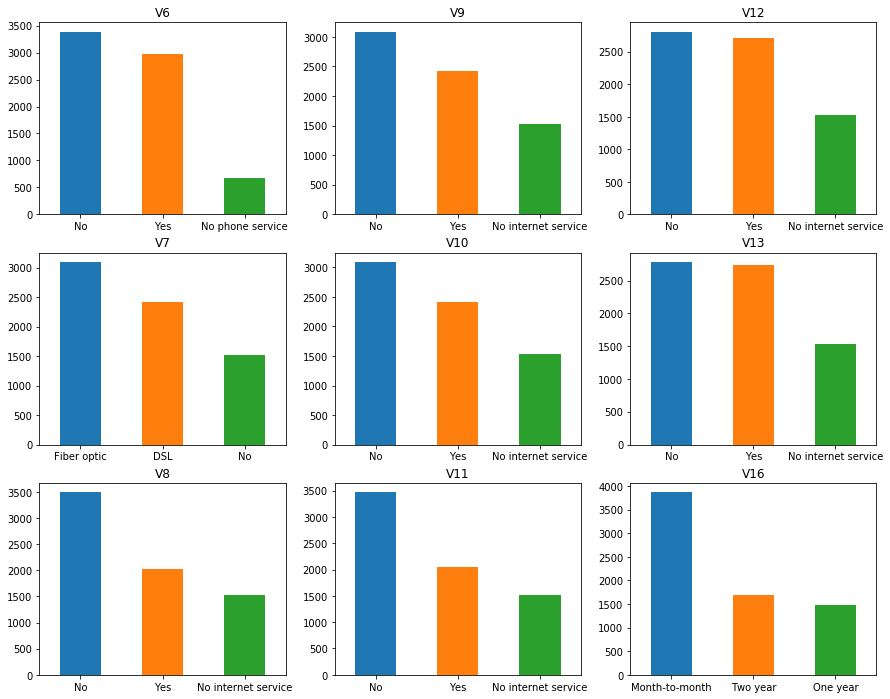

In [17]:
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(Multi_class):
    if i < 3:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

* Look at binary class variables distribution 

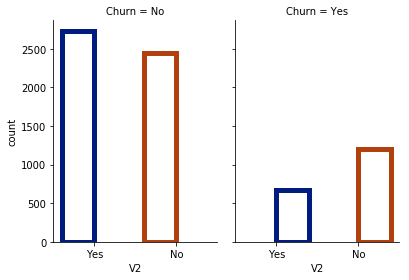

In [18]:
#Tdata.groupby('V2')['Churn'].count().plot(kind = 'barh')
#sns.countplot(x="Churn", hue="V2", data=Tdata)
sns.catplot(x="V2", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

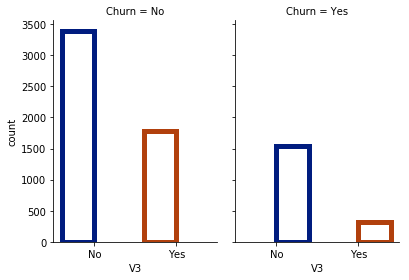

In [19]:
#Tdata.groupby('V3')['Churn'].count().plot(kind = 'barh')
sns.catplot(x="V3", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

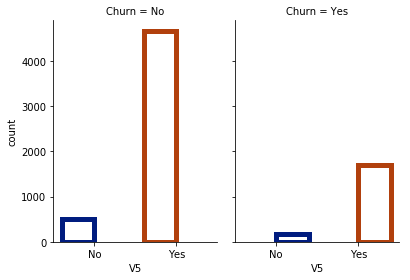

In [20]:
#Tdata.groupby('V5')['Churn'].count().plot(kind = 'barh')
sns.catplot(x="V5", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

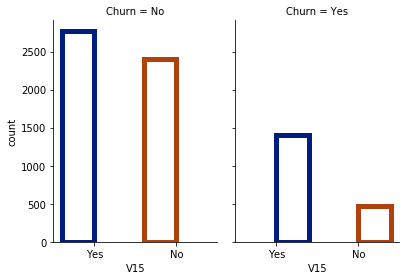

In [21]:
#Tdata.groupby('V15')['Churn'].count().plot(kind = 'barh')
sns.catplot(x="V15", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

### Tranforming the data

In [22]:
#Label encoding Binary columns
le = LabelEncoder()
for i in Binary_class :
    Tdata[i] = le.fit_transform(Tdata[i])

In [23]:
Tdata[Binary_class].shape

(7043, 6)

In [24]:
Tdata[Num_cols].shape

(7043, 4)

In [25]:
# Split multi class catergory columns as dummies  
Tdata_Dummy = pd.get_dummies(Tdata[Multi_class])
Tdata_Dummy.head()


,V6_No,V6_No phone service,V6_Yes,V7_DSL,V7_Fiber optic,V7_No,V8_No,V8_No internet service,V8_Yes,V9_No,V9_No internet service,V9_Yes,V10_No,V10_No internet service,V10_Yes,V11_No,V11_No internet service,V11_Yes,V12_No,V12_No internet service,V12_Yes,V13_No,V13_No internet service,V13_Yes,V14_Month-to-month,V14_One year,V14_Two year,V16_Bank transfer (automatic),V16_Credit card (automatic),V16_Electronic check,V16_Mailed check
0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [26]:
New_df = pd.concat([Tdata[Num_cols],Tdata[Binary_class],Tdata_Dummy], axis=1)
New_df.shape

(7043, 41)

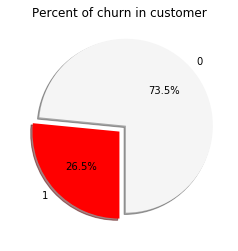

In [27]:
# Data to plot
labels =New_df['Churn'].value_counts(sort = True).index
sizes = New_df['Churn'].value_counts(sort = True)

colors = ["whitesmoke","red"]
explode = (0.1,0)  # explode 1st slice
 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=270,)

plt.title('Percent of churn in customer')
plt.show()

### correlation
* Lets check the correlation between the variables 

In [28]:
#correlation
corr = New_df.corr()

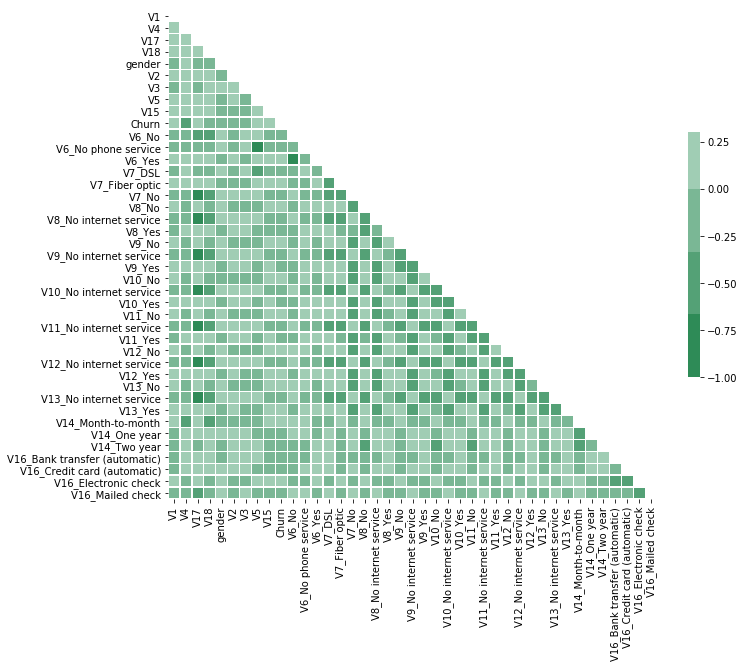

In [29]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap=sns.light_palette("seagreen", reverse=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

From the above heatmap we can see the highly correlated variables with dark green associated        
For example                         
V4 variable is highly correlated with **V14 Month to Month** and **Churn** 
V17 is correlated with most of the variables with No internete service and NO classes 

Like the above examples we can interpret the variables with most correlated in the same data set 

### Important variables 

In [30]:
X = New_df.loc[:, New_df.columns != 'Churn']
y = New_df["Churn"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =1)

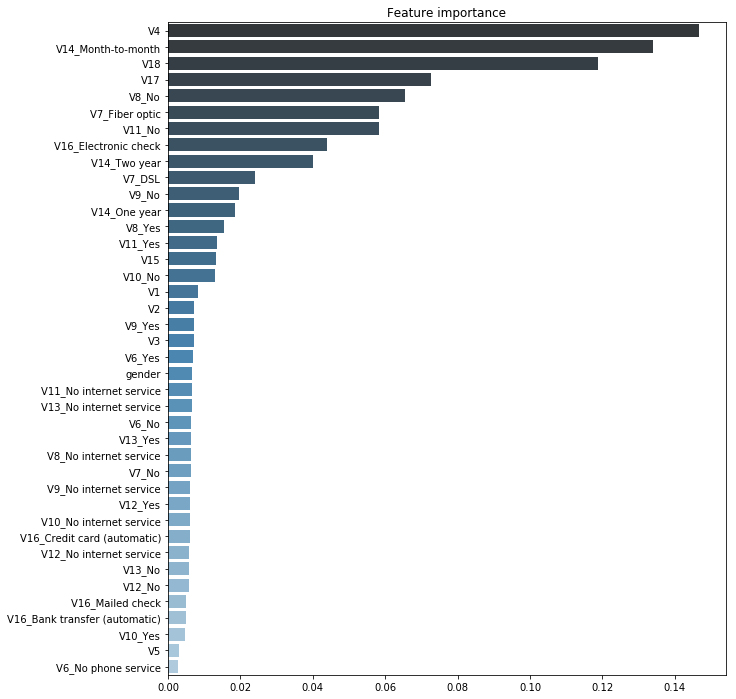

In [31]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}

# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(X, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

* Since V4 having the highest important variables lets look more closely 

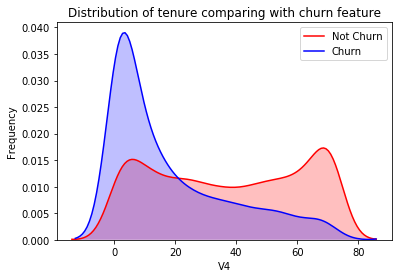

In [32]:
# V4 distibution 
g = sns.kdeplot(New_df.V4[(New_df["Churn"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(New_df.V4[(New_df["Churn"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("V4")
g.set_ylabel("Frequency")
plt.title('Distribution of tenure comparing with churn feature')
g = g.legend(["Not Churn","Churn"])

* There is a chnace that customer will churn based on V4 . Lesser the range more chance of churn 

In [33]:
print(sorted(New_df["V4"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


* According to above important variables plot, V17 & V18  may affect to churn probability.
* And seem like customer will not churn if they have lower range 

#### Split train and test 

In [34]:
X = New_df.loc[:, New_df.columns != 'Churn']
y = New_df["Churn"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =1)

In [35]:
print('The number of samples into the Train data is {}.'.format(x_train.shape[0]))
print('The number of samples into the test data is {}.'.format(x_test.shape[0]))

The number of samples into the Train data is 5634.
The number of samples into the test data is 1409.


In [36]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
accuracy = logistic_model.score(x_test,y_test)
print("Logistic Regression accuracy is :",accuracy*100)

Logistic Regression accuracy is : 81.12136266855926


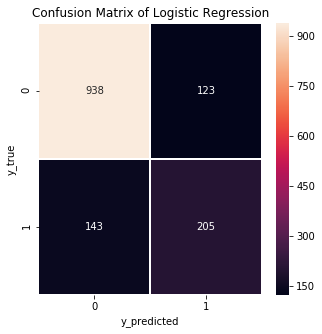

In [38]:
#from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
#for Logistic Regression
cm_lr = confusion_matrix(y_test,logistic_model.predict(x_test))

# %% confusion matrix visualization
import seaborn as sns
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm_lr, annot = True, linewidths = 0.5, color = "red", fmt = ".0f", ax=ax)
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

* ### Using Grid search CV and L2 Penality for logistic regression

In [39]:
# Define Model parameters to tune
model_parameters = {
        'C': [1,10,100,1000],
        'class_weight': ['balanced', None]
    }

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Gridsearch the parameters to find the best parameters. Using L2 penalty
model = LogisticRegression(penalty='l2')
gscv = GridSearchCV(estimator=model, 
                    param_grid=model_parameters, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1')

gscv.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [41]:
print('The best parameter are -', gscv.best_params_)

The best parameter are - {'C': 1000, 'class_weight': 'balanced'}


In [42]:
# Re-fit the model with the best parameters
#final_mod = LogisticRegression(penalty='l2', C=1000, class_weight='balanced')
final_mod = LogisticRegression(**gscv.best_params_)
final_mod.fit(x_train,y_train)



LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [43]:
# View the model coefficients
list(zip(x_train.columns, final_mod.coef_[0]))

[('V1', 0.18284189793417094),
 ('V4', -0.05526868110886139),
 ('V17', 0.006018577347233037),
 ('V18', 0.00029183240721932684),
 ('gender', -0.02978813306960922),
 ('V2', 0.026476105448407353),
 ('V3', -0.07530996676159457),
 ('V5', -0.24129181113625697),
 ('V15', 0.3067026874481722),
 ('V6_No', -0.20064330272866196),
 ('V6_No phone service', 0.17639350628685208),
 ('V6_Yes', -0.040648508407607704),
 ('V7_DSL', -0.2832258759238238),
 ('V7_Fiber optic', 0.2932553724498367),
 ('V7_No', -0.07492780137540918),
 ('V8_No', 0.20906195446172868),
 ('V8_No internet service', -0.07492780137540918),
 ('V8_Yes', -0.19903245793571217),
 ('V9_No', 0.10341689110188587),
 ('V9_No internet service', -0.07492780137540918),
 ('V9_Yes', -0.093387394575886),
 ('V10_No', 0.07734916295589345),
 ('V10_No internet service', -0.07492780137540918),
 ('V10_Yes', -0.06731966642990399),
 ('V11_No', 0.17680385641051252),
 ('V11_No internet service', -0.07492780137540918),
 ('V11_Yes', -0.16677435988450034),
 ('V12_No

In [44]:
confusion_matrix(y_test,final_mod.predict(x_test))

array([[773, 288],
       [ 57, 291]])

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test,final_mod.predict(x_test)))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1061
           1       0.50      0.84      0.63       348

   micro avg       0.76      0.76      0.76      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.83      0.76      0.77      1409



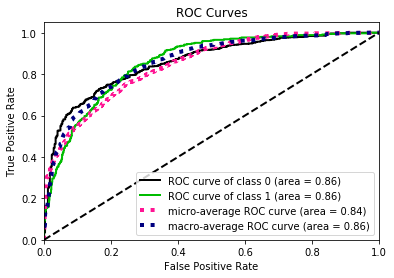

In [46]:
# Generate ROC

import scikitplot as skplt
import matplotlib.pyplot as plt

#y_test = # ground truth labels
#predict_proba = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test,final_mod.predict_proba(x_test))
plt.show()

AUC: 0.782


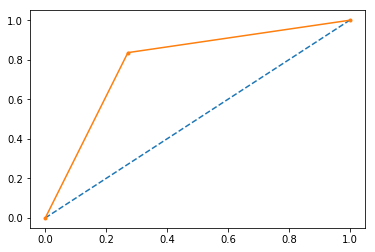

In [47]:
auc = roc_auc_score(y_test, final_mod.predict(x_test))
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, final_mod.predict(x_test))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

# END OF NOTEBOOK